In [5]:
%matplotlib inline

# importing libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import cufflinks as cf
import seaborn as sns
import pandas as pd
import numpy as np
import quandl
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from pandas.core.base import PandasObject
from datetime import datetime

pd.options.display.float_format = '{:,.5f}'.format

# Setting pandas dataframe display options
pd.set_option("display.max_rows", None)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

# Set cufflinks offline
cf.go_offline()

# Defining today's Date
from datetime import date
today = date.today()

import PortfolioLab as pl

[<img style="float: right;" src="https://www.futureproof.pt/files/f_photos/f_shares/logo-future-proof_smaller.png" alt="FP" border="0">](https://www.futureproof.pt/)

In [6]:
ISINs = ['IE00B18GC888', 'IWDA', 'XAD5']
Nomes = ['VG_GB', 'IWDA', 'XAD5']

fundos = pd.read_csv('D:/GDrive/_GitHub/Backtester/Data/Cotacoes_diarias_all.csv', index_col = 'Date', parse_dates = True)[ISINs]['2015-06-23':]

fundos.columns = Nomes
fundos = fundos.dropna()
fundos = pl.normalize(fundos)

Begin = str(fundos.iloc[0].name)[0:10]
End = str(fundos.iloc[-1].name)[0:10]

In [7]:
returns = fundos.pct_change()

In [8]:
returns.head()

VG_GB  IWDA  XAD5
Date                         
2015-06-23    nan   nan   nan
2015-06-24   0.00 -0.00 -0.00
2015-06-25  -0.00 -0.00 -0.00
2015-06-26  -0.00 -0.00  0.00
2015-06-27   0.00  0.00  0.00

In [9]:
returns.corr()

VG_GB  IWDA  XAD5
VG_GB   1.00 -0.14  0.31
IWDA   -0.14  1.00  0.04
XAD5    0.31  0.04  1.00

In [10]:
from pandas.tseries.offsets import DateOffset
plus_1_year = returns.iloc[0].name + DateOffset(years=1)

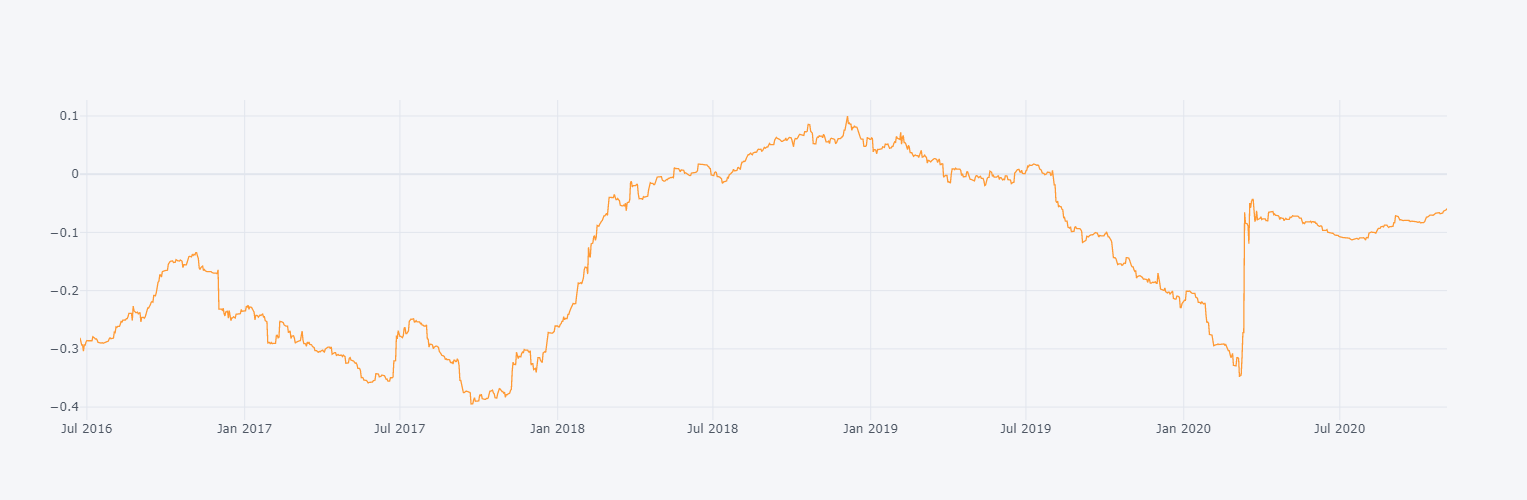

In [11]:
returns['VG_GB'].rolling("365D").corr(returns['IWDA'])[plus_1_year:].iplot(dimensions=pl.dimensions)

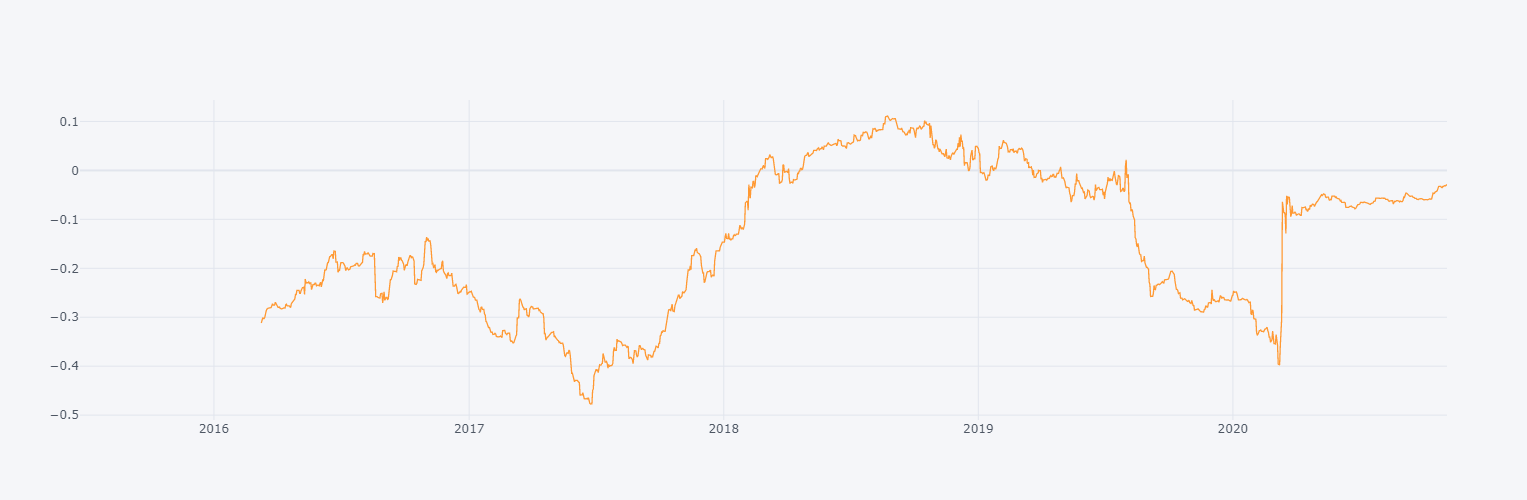

In [12]:
returns['VG_GB'].rolling(260).corr(returns['IWDA']).iplot(dimensions=pl.dimensions)

### Comparação de carteiras "modelo" de ETFs (usando Vanguard Global Bond e IWDA)

In [13]:
pl.print_title('Análise desde ' +  Begin + ' até ' + End)

**Análise desde 2015-06-23 até 2020-11-03**

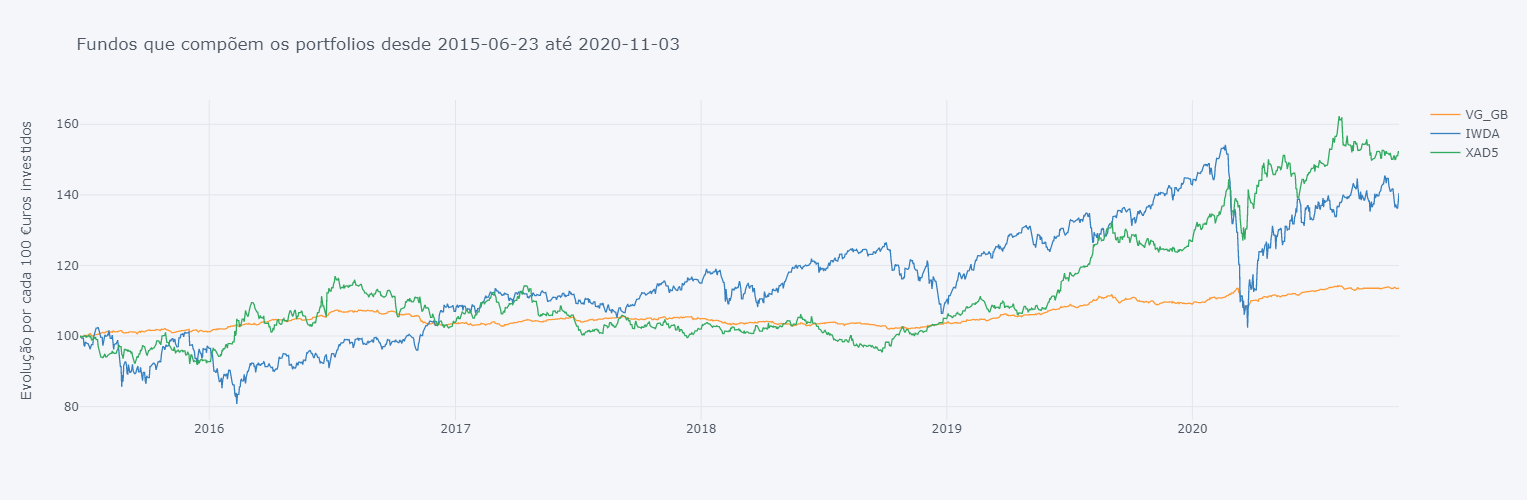

In [14]:
fundos.iplot(dimensions=pl.dimensions, title='Fundos que compõem os portfolios desde ' +  Begin + ' até ' + End,
             yTitle='Evolução por cada 100 €uros investidos')

In [15]:
# nr = 0

# pl.print_title('Quadro de performance de ' + fundos.columns[nr])
# pl.compute_ms_performance_table(fundos[[fundos.columns[nr]]])

In [16]:
# nr = 1

# pa.print_title('Quadro de performance de ' + fundos.columns[nr])
# pa.compute_ms_performance_table(fundos[[fundos.columns[nr]]])

In [34]:
def compute_portfolio(quotes, weights, rebalance='yearly', start_amount=100):
    from datetime import datetime
    from dateutil.relativedelta import relativedelta

    Start = quotes.index[0]
    End = quotes.index[-1]
    more_than_year = pd.to_datetime(Start) + relativedelta(months=12) < pd.to_datetime(End)
    more_than_quarter = pd.to_datetime(Start) + relativedelta(months=3) < pd.to_datetime(End)
    more_than_month = pd.to_datetime(Start) + relativedelta(months=1) <= pd.to_datetime(End)

    returns_all = pd.DataFrame()
    quotes_pesos_all = pd.DataFrame()
    weights_all = pd.DataFrame()
    rc_all = pd.DataFrame()
    n = -1
    
    anos = pd.DataFrame(list(set(quotes.index.year))).sort_values(by=0).reset_index()[0]
    
    if rebalance == 'yearly' and more_than_year:
        rebalance_dates = pd.bdate_range(start=Start, end=End, freq='A')
    elif rebalance == 'yearly':
        rebalance_dates = pd.to_datetime([End])
    elif rebalance == 'quarterly' and more_than_quarter:
        rebalance_dates = pd.bdate_range(start=Start, end=End, freq='Q')
    elif rebalance == 'quarterly':
        rebalance_dates = pd.to_datetime([End])    
    elif rebalance == 'monthly' and more_than_month:
        rebalance_dates = pd.bdate_range(start=Start, end=End, freq='M')
    elif rebalance == 'quarterly':
        rebalance_dates = pd.to_datetime([End])
    elif rebalance == False:
        rebalance_dates = pd.to_datetime([End]) 
    

    for i in np.arange(len(rebalance_dates)):
        n+=1
        break_point_future = rebalance_dates[n]
        break_point_past = rebalance_dates[n-1]
        # Até ao primeiro breakpoint
        if n == 0:
            quotes_norm_periodo = pl.normalize(quotes[:break_point_future])
            quotes_pesos_periodo = quotes_norm_periodo * np.array(weights)
            quotes_pesos_periodo_soma = quotes_pesos_periodo.sum(axis=1)
            returns_periodo = quotes_pesos_periodo_soma.pct_change().dropna()
            returns_all = pd.concat([returns_all, returns_periodo])
            weights_all = pd.concat([weights_all, quotes_pesos_periodo])
            quotes_pesos_all = pd.concat([quotes_pesos_all, quotes_pesos_periodo])
            rc_period = risk_contribution(quotes_pesos_periodo.mean(), quotes.pct_change().dropna().cov())
            rc_all[str(anos[n])] = rc_period
        # # Break points a seguir
        if n > 0 and n < len(rebalance_dates):
            quotes_norm_periodo = pl.normalize(quotes[break_point_past:break_point_future])
            quotes_pesos_periodo = quotes_norm_periodo * np.array(weights)
            quotes_pesos_periodo_soma = quotes_pesos_periodo.sum(axis=1)
            returns_periodo = quotes_pesos_periodo_soma.pct_change().dropna()
            returns_all = pd.concat([returns_all, returns_periodo])
            weights_all = pd.concat([weights_all, quotes_pesos_periodo])
            quotes_pesos_all = pd.concat([quotes_pesos_all, quotes_pesos_periodo])
            rc_period = risk_contribution(quotes_pesos_periodo.mean(), quotes.pct_change().dropna().cov())
            rc_all[str(anos[n])] = rc_period
        # last break point
        if n == len(rebalance_dates) - 1:
            # print(n)
            quotes_norm_periodo = pl.normalize(quotes[break_point_future:])
            quotes_pesos_periodo = quotes_norm_periodo * np.array(weights)
            quotes_pesos_periodo_soma = quotes_pesos_periodo.sum(axis=1)
            returns_periodo = quotes_pesos_periodo_soma.pct_change().dropna()
            returns_all = pd.concat([returns_all, returns_periodo])
            weights_all = pd.concat([weights_all, quotes_pesos_periodo])
            quotes_pesos_all = pd.concat([quotes_pesos_all, quotes_pesos_periodo])
            rc_period = risk_contribution(quotes_pesos_periodo.mean(), quotes.pct_change().dropna().cov())
            rc_all[str(anos[n + 1])] = rc_period

    portfolio = pl.normalize(pl.compute_time_series(returns_all)) * (start_amount/100)
    portfolio = portfolio[~portfolio.index.duplicated(keep='first')]
    weights_all = weights_all[~weights_all.index.duplicated(keep='first')]
    quotes_pesos_all = quotes_pesos_all[~quotes_pesos_all.index.duplicated(keep='first')]
    weights_all = weights_all.div(weights_all.sum(axis=1), axis=0)
    weights_all = weights_all[:-1]
    
    return portfolio, weights_all, quotes_pesos_all, rc_all

In [35]:
agressivo, weights_agressivo, quotes_pesos_all_agressivo, rc_agressivo = compute_portfolio(fundos, [0.2, 0.6, 0.2], rebalance='yearly')
moderado, weights_moderado, quotes_pesos_all_moderado, rc_moderado = compute_portfolio(fundos, [0.25, 0.5, 0.25], rebalance='yearly')
conservador, weights_conservador, quotes_pesos_all_conservador, rc_conservador = compute_portfolio(fundos, [0.7, 0.15, 0.15], rebalance='yearly')

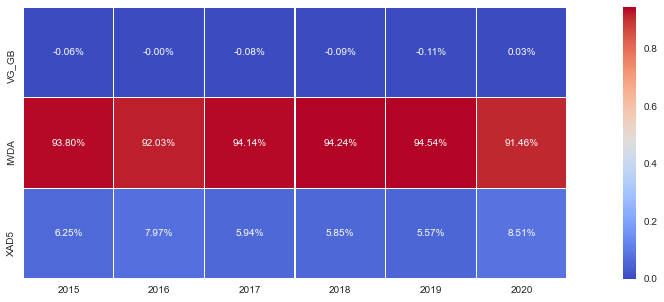

In [36]:
plt.figure(figsize=(20,5));
sns.heatmap(pd.DataFrame(rc_agressivo), annot=True, cmap='coolwarm', square=True, linewidths=0.1, fmt='.2%');

In [109]:
pd.set_option("display.max_rows", 20)
c_moderado.tail(6)

VG_GB  IWDA  XAD5  Portfolio
Date                                    
2020-10-29   2.93 -0.59  2.74       5.09
2020-10-30   2.80 -0.69  2.86       4.97
2020-10-31   2.80 -0.69  2.86       4.97
2020-11-01   2.80 -0.69  2.86       4.97
2020-11-02   2.88 -0.49  3.00       5.39
2020-11-03   2.88 -0.25  3.00       5.63

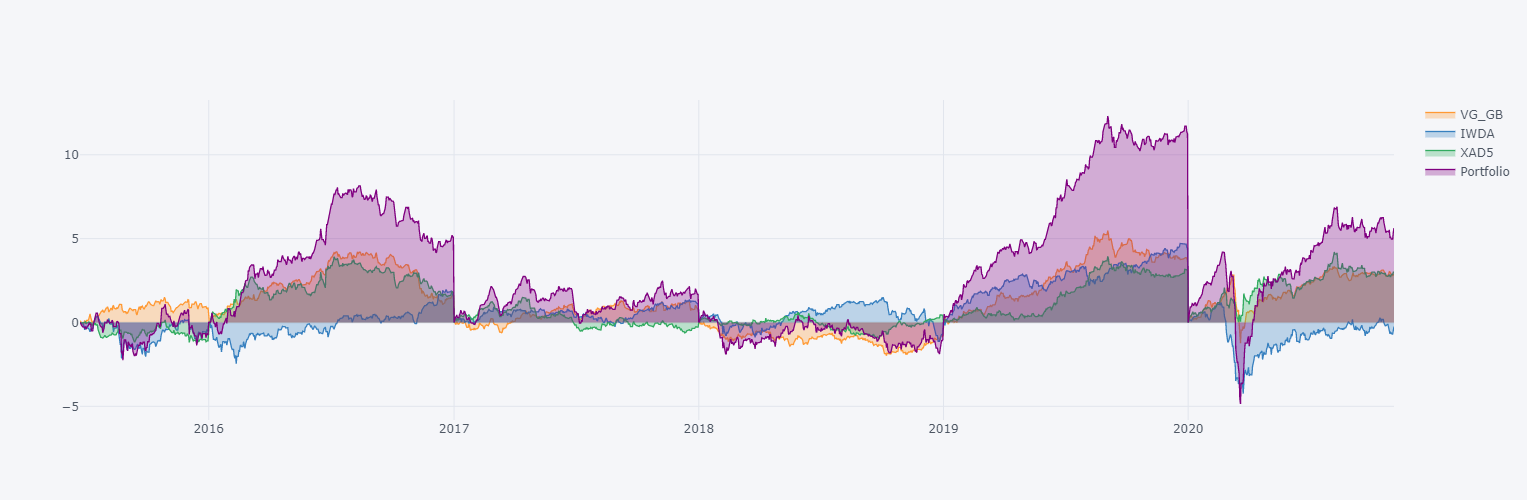

In [105]:
c_moderado = quotes_pesos_all_conservador.copy() - (np.array([0.7, 0.15, 0.15]) *100)
c_moderado['Portfolio'] = quotes_pesos_all_conservador.sum(axis=1) - 100
round(c_moderado, 2).iplot(dimensions=pl.dimensions, fill=True)

In [19]:
def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    vol = (weights.T @ covmat @ weights)**0.5
    return vol 

In [20]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov @ w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

In [177]:
cov = fundos.pct_change().dropna().cov()
cov

VG_GB      IWDA     XAD5
VG_GB  2.05e-06 -1.82e-06 2.85e-06
IWDA  -1.82e-06  8.39e-05  2.1e-06
XAD5   2.85e-06   2.1e-06 4.07e-05

In [178]:
weights_moderado.mean()

VG_GB   0.247
IWDA    0.502
XAD5    0.251
dtype: float64

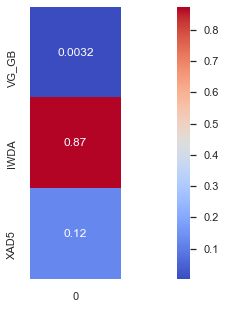

In [179]:
import seaborn as sns

data = risk_contribution(weights_moderado.mean(), fundos.pct_change().dropna().cov())
plt.figure(figsize=(20,5));
sns.heatmap(pd.DataFrame(data), annot=True, cmap='coolwarm', square=True);

In [204]:
%%time
risk_contribution_2 = risk_contribution(weights_moderado.mean(), fundos.pct_change().dropna().cov())

Wall time: 4.99 ms


In [163]:
pd.options.display.float_format = '{:,.3}'.format
weights_moderado

VG_GB  IWDA  XAD5
Date                         
2015-06-23   0.25   0.5  0.25
2015-06-24  0.251   0.5 0.249
2015-06-25  0.251 0.499  0.25
2015-06-26   0.25 0.499 0.251
2015-06-27   0.25 0.499 0.251
...           ...   ...   ...
2020-10-29  0.253 0.496 0.251
2020-10-30  0.253 0.494 0.253
2020-10-31  0.253 0.494 0.253
2020-11-01  0.253 0.494 0.253
2020-11-02  0.251 0.496 0.253

[1960 rows x 3 columns]

In [113]:
c_moderado.loc['2019-05-06'] + c_moderado.loc['2020-05-06']

VG_GB       2.98
IWDA        1.13
XAD5        2.70
Portfolio   6.81
dtype: float64

In [108]:
pd.set_option("display.max_rows", 10)
conservador['2019-05-06':'2020-05-06']

0
2019-05-06 109.88
2019-05-07 109.79
2019-05-08 109.61
2019-05-09 109.31
2019-05-10 109.39
...           ...
2020-05-02 119.65
2020-05-03 119.65
2020-05-04 119.16
2020-05-05 119.70
2020-05-06 119.36

[367 rows x 1 columns]

In [110]:
119.36/109.88

1.0862759373862396

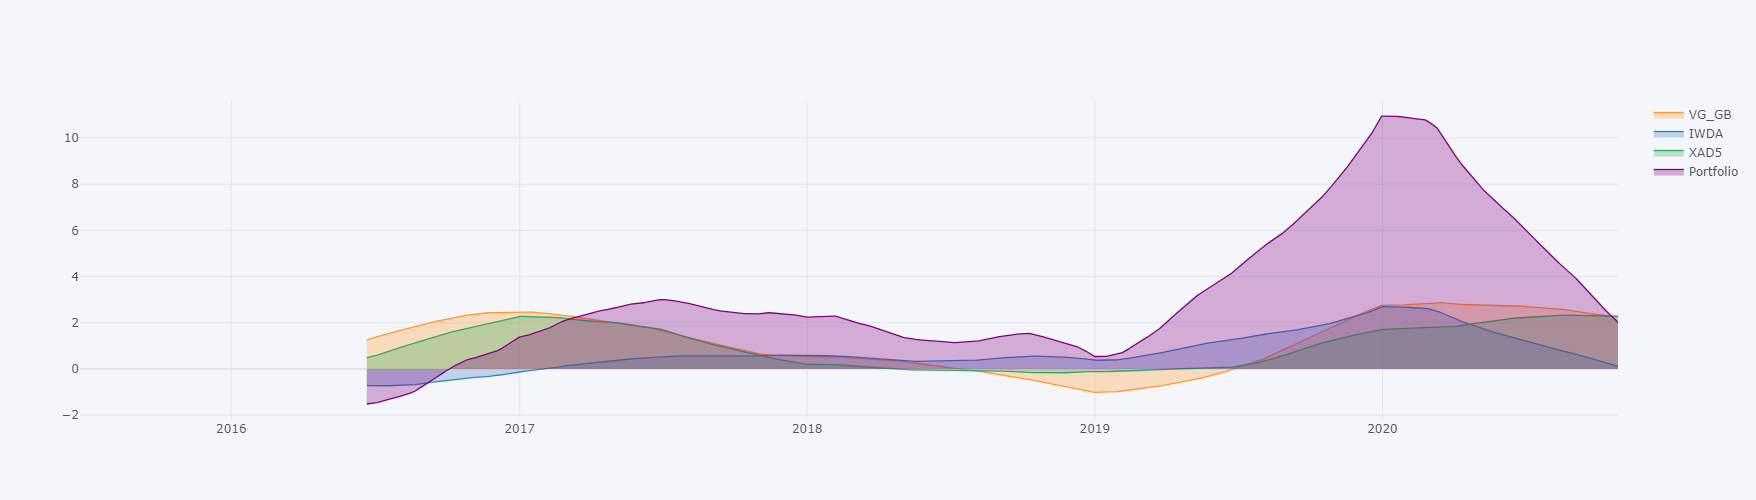

In [104]:
data = c_moderado.rolling(365).sum()
data['Portfolio'] = Portfolio.rolling(365).sum()
data = data / 365
data.iplot(dimensions=pl.dimensions, fill=True)

In [59]:
moderado.columns = ['Moderado']

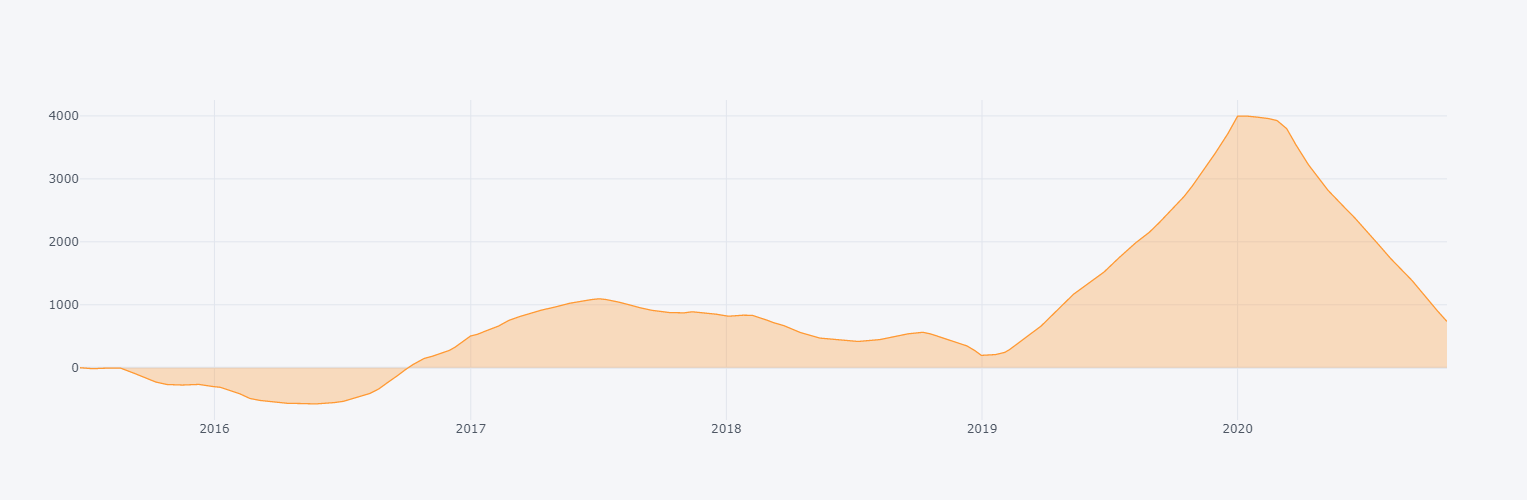

In [34]:
Portfolio.iplot(dimensions=pl.dimensions, fill=True)

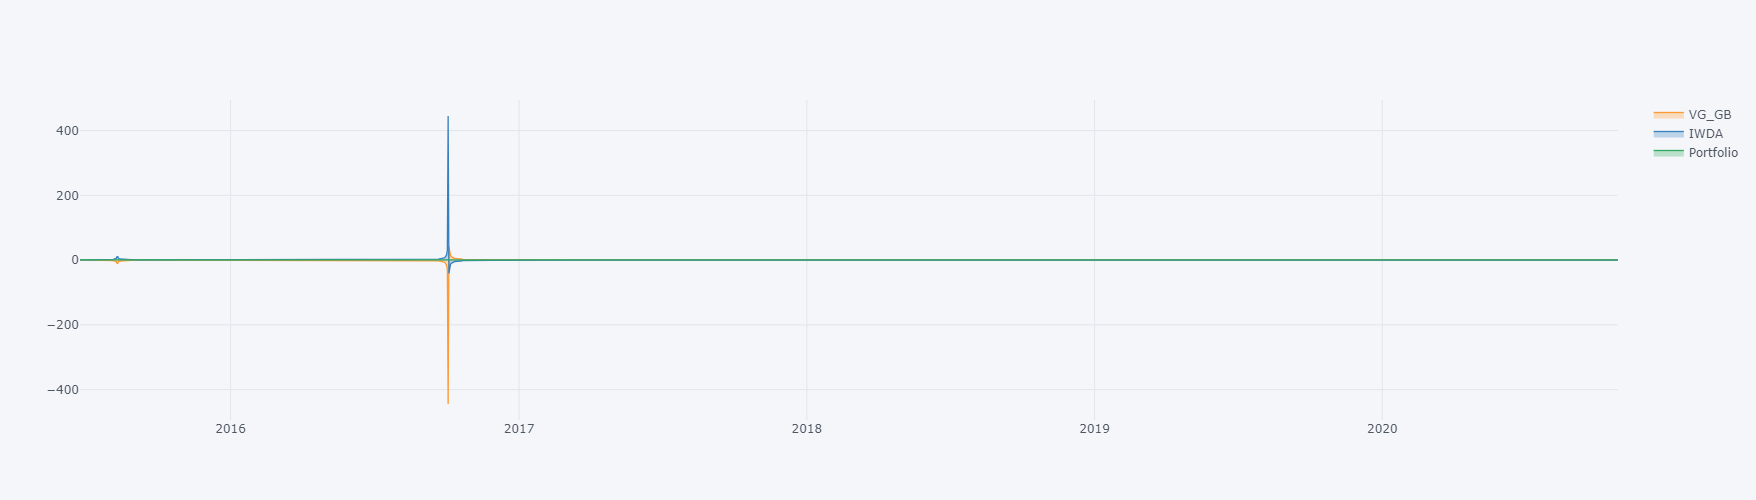

Wall time: 115 ms


In [57]:
%%time
contributions = data.div(data.sum(axis=1), axis=0)


round(contributions[:], 2).dropna().iplot(dimensions=pl.dimensions, fill=True)

In [18]:
pd.set_option("display.max_rows", None)
data

VG_GB     IWDA
Date                       
2015-06-23    0.00     0.00
2015-06-24    0.05    -0.11
2015-06-25    0.04    -0.37
2015-06-26   -0.07    -0.67
2015-06-27   -0.17    -0.98
2015-06-28   -0.28    -1.29
2015-06-29   -0.20    -2.59
2015-06-30   -0.11    -4.07
2015-07-01   -0.14    -4.91
2015-07-02   -0.18    -5.88
2015-07-03   -0.09    -6.97
2015-07-04    0.00    -8.06
2015-07-05    0.09    -9.15
2015-07-06    0.23   -10.36
2015-07-07    0.53   -11.86
2015-07-08    0.89   -13.73
2015-07-09    1.11   -15.06
2015-07-10    1.14   -16.29
2015-07-11    1.16   -17.52
2015-07-12    1.18   -18.74
2015-07-13    1.17   -18.95
2015-07-14    1.22   -18.84
2015-07-15    1.39   -18.44
2015-07-16    1.59   -17.46
2015-07-17    1.85   -16.34
2015-07-18    2.11   -15.21
2015-07-19    2.37   -14.08
2015-07-20    2.63   -12.84
2015-07-21    2.90   -12.11
2015-07-22    3.24   -11.59
2015-07-23    3.65   -11.42
2015-07-24    4.13   -11.62
2015-07-25    4.61   -11.83
2015-07-26    5.09   -12.03
2015-07-27    5.61   -13.39
2015-07-28    6.08   -14.21
2015-07-29    6.51   -14.47
2015-07-30    7.00   -14.30
2015-07-31    7.60   -14.31
2015-08-01    8.21   -14.31
2015-08-02    8.82   -14.32
2015-08-03    9.49   -14.13
2015-08-04   10.09   -14.03
2015-08-05   10.53   -13.23
2015-08-06   11.03   -13.14
2015-08-07   11.62   -13.48
2015-08-08   12.22   -13.82
2015-08-09   12.82   -14.15
2015-08-10   13.34   -14.01
2015-08-11   14.04   -14.73
2015-08-12   14.75   -16.64
2015-08-13   15.37   -17.83
2015-08-14   15.95   -18.92
2015-08-15   16.52   -20.02
2015-08-16   17.10   -21.11
2015-08-17   17.74   -21.89
2015-08-18   18.32   -22.48
2015-08-19   18.98   -23.89
2015-08-20   19.71   -26.35
2015-08-21   20.49   -30.68
2015-08-22   21.26   -35.02
2015-08-23   22.03   -39.35
2015-08-24   22.80   -46.53
2015-08-25   23.34   -52.06
2015-08-26   23.80   -58.51
2015-08-27   24.24   -62.68
2015-08-28   24.70   -66.36
2015-08-29   25.15   -70.04
2015-08-30   25.61   -73.72
2015-08-31   26.00   -77.77
2015-09-01   26.43   -83.11
2015-09-02   26.83   -88.51
2015-09-03   27.31   -92.55
2015-09-04   27.91   -97.70
2015-09-05   28.51  -102.85
2015-09-06   29.10  -108.00
2015-09-07   29.68  -113.05
2015-09-08   30.20  -117.73
2015-09-09   30.73  -121.75
2015-09-10   31.23  -126.68
2015-09-11   31.78  -132.02
2015-09-12   32.34  -137.36
2015-09-13   32.89  -142.70
2015-09-14   33.44  -147.91
2015-09-15   33.81  -152.71
2015-09-16   34.13  -156.99
2015-09-17   34.57  -161.25
2015-09-18   35.22  -166.33
2015-09-19   35.87  -171.42
2015-09-20   36.52  -176.50
2015-09-21   37.06  -180.94
2015-09-22   37.74  -186.30
2015-09-23   38.40  -191.66
2015-09-24   39.10  -197.98
2015-09-25   39.68  -203.14
2015-09-26   40.27  -208.31
2015-09-27   40.85  -213.48
2015-09-28   41.53  -219.81
2015-09-29   42.24  -226.58
2015-09-30   42.94  -232.23
2015-10-01   43.70  -238.05
2015-10-02   44.58  -243.93
2015-10-03   45.46  -249.82
2015-10-04   46.34  -255.71
2015-10-05   47.12  -260.03
2015-10-06   47.90  -264.35
2015-10-07   48.66  -268.54
2015-10-08   49.39  -272.55
2015-10-09   50.10  -276.40
2015-10-10   50.82  -280.25
2015-10-11   51.53  -284.10
2015-10-12   52.34  -288.04
2015-10-13   53.15  -292.13
2015-10-14   54.08  -296.93
2015-10-15   54.96  -301.19
2015-10-16   55.84  -304.86
2015-10-17   56.72  -308.52
2015-10-18   57.61  -312.19
2015-10-19   58.48  -315.75
2015-10-20   59.26  -319.43
2015-10-21   60.14  -323.06
2015-10-22   61.12  -325.62
2015-10-23   62.04  -327.14
2015-10-24   62.96  -328.67
2015-10-25   63.88  -330.19
2015-10-26   64.86  -331.80
2015-10-27   65.94  -333.78
2015-10-28   66.95  -335.34
2015-10-29   67.78  -336.56
2015-10-30   68.64  -338.00
2015-10-31   69.49  -339.44
2015-11-01   70.35  -340.88
2015-11-02   71.14  -342.24
2015-11-03   71.87  -343.07
2015-11-04   72.55  -343.58
2015-11-05   73.22  -344.27
2015-11-06   73.70  -344.63
2015-11-07   74.18  -344.99
2015-11-08   74.66  -345.35
2015-11-09   75.08  -346.21
2015-11-10   75.60  -346.74
2015-11-1

In [19]:
c_moderado

VG_GB   IWDA
Date                    
2015-06-23   0.00   0.00
2015-06-24   0.05  -0.11
2015-06-25  -0.01  -0.25
2015-06-26  -0.11  -0.31
2015-06-27  -0.11  -0.31
2015-06-28  -0.11  -0.31
2015-06-29   0.08  -1.30
2015-06-30   0.09  -1.48
2015-07-01  -0.03  -0.85
2015-07-02  -0.04  -0.97
2015-07-03   0.09  -1.09
2015-07-04   0.09  -1.09
2015-07-05   0.09  -1.09
2015-07-06   0.13  -1.22
2015-07-07   0.31  -1.50
2015-07-08   0.36  -1.87
2015-07-09   0.22  -1.32
2015-07-10   0.02  -1.23
2015-07-11   0.02  -1.23
2015-07-12   0.02  -1.23
2015-07-13  -0.01  -0.20
2015-07-14   0.05   0.11
2015-07-15   0.16   0.39
2015-07-16   0.20   0.98
2015-07-17   0.26   1.13
2015-07-18   0.26   1.13
2015-07-19   0.26   1.13
2015-07-20   0.26   1.25
2015-07-21   0.28   0.73
2015-07-22   0.34   0.52
2015-07-23   0.40   0.17
2015-07-24   0.48  -0.20
2015-07-25   0.48  -0.20
2015-07-26   0.48  -0.20
2015-07-27   0.52  -1.36
2015-07-28   0.47  -0.81
2015-07-29   0.42  -0.26
2015-07-30   0.49   0.17
2015-07-31   0.61  -0.01
2015-08-01   0.61  -0.01
2015-08-02   0.61  -0.01
2015-08-03   0.67   0.19
2015-08-04   0.60   0.10
2015-08-05   0.44   0.81
2015-08-06   0.50   0.08
2015-08-07   0.60  -0.34
2015-08-08   0.60  -0.34
2015-08-09   0.60  -0.34
2015-08-10   0.52   0.15
2015-08-11   0.70  -0.73
2015-08-12   0.71  -1.90
2015-08-13   0.61  -1.19
2015-08-14   0.58  -1.09
2015-08-15   0.58  -1.09
2015-08-16   0.58  -1.09
2015-08-17   0.64  -0.78
2015-08-18   0.58  -0.59
2015-08-19   0.65  -1.41
2015-08-20   0.74  -2.46
2015-08-21   0.77  -4.33
2015-08-22   0.77  -4.33
2015-08-23   0.77  -4.33
2015-08-24   0.77  -7.18
2015-08-25   0.54  -5.52
2015-08-26   0.46  -6.45
2015-08-27   0.44  -4.18
2015-08-28   0.46  -3.68
2015-08-29   0.46  -3.68
2015-08-30   0.46  -3.68
2015-08-31   0.39  -4.05
2015-09-01   0.43  -5.35
2015-09-02   0.40  -5.39
2015-09-03   0.48  -4.05
2015-09-04   0.60  -5.15
2015-09-05   0.60  -5.15
2015-09-06   0.60  -5.15
2015-09-07   0.57  -5.05
2015-09-08   0.53  -4.68
2015-09-09   0.53  -4.02
2015-09-10   0.50  -4.93
2015-09-11   0.55  -5.34
2015-09-12   0.55  -5.34
2015-09-13   0.55  -5.34
2015-09-14   0.55  -5.21
2015-09-15   0.37  -4.80
2015-09-16   0.32  -4.28
2015-09-17   0.44  -4.25
2015-09-18   0.65  -5.09
2015-09-19   0.65  -5.09
2015-09-20   0.65  -5.09
2015-09-21   0.54  -4.44
2015-09-22   0.69  -5.36
2015-09-23   0.66  -5.35
2015-09-24   0.70  -6.32
2015-09-25   0.58  -5.17
2015-09-26   0.58  -5.17
2015-09-27   0.58  -5.17
2015-09-28   0.68  -6.33
2015-09-29   0.71  -6.77
2015-09-30   0.70  -5.65
2015-10-01   0.76  -5.82
2015-10-02   0.88  -5.89
2015-10-03   0.88  -5.89
2015-10-04   0.88  -5.89
2015-10-05   0.78  -4.32
2015-10-06   0.78  -4.32
2015-10-07   0.76  -4.19
2015-10-08   0.73  -4.01
2015-10-09   0.72  -3.85
2015-10-10   0.72  -3.85
2015-10-11   0.72  -3.85
2015-10-12   0.80  -3.94
2015-10-13   0.81  -4.09
2015-10-14   0.93  -4.79
2015-10-15   0.88  -4.26
2015-10-16   0.88  -3.67
2015-10-17   0.88  -3.67
2015-10-18   0.88  -3.67
2015-10-19   0.87  -3.56
2015-10-20   0.78  -3.69
2015-10-21   0.88  -3.63
2015-10-22   0.98  -2.56
2015-10-23   0.92  -1.52
2015-10-24   0.92  -1.52
2015-10-25   0.92  -1.52
2015-10-26   0.98  -1.62
2015-10-27   1.07  -1.97
2015-10-28   1.01  -1.57
2015-10-29   0.83  -1.22
2015-10-30   0.86  -1.44
2015-10-31   0.86  -1.44
2015-11-01   0.86  -1.44
2015-11-02   0.78  -1.36
2015-11-03   0.73  -0.83
2015-11-04   0.69  -0.52
2015-11-05   0.66  -0.68
2015-11-06   0.48  -0.36
2015-11-07   0.48  -0.36
2015-11-08   0.48  -0.36
2015-11-09   0.42  -0.86
2015-11-10   0.51  -0.53
2015-11-11   0.51  -0.49
2015-11-12   0.55  -1.11
2015-11-13   0.63  -1.54
2015-11-14   0.63  -1.54
2015-11-15   0.63  -1.54
2015-11-16   0.67  -1.49
2015-11-17   0.68  -0.27
2015-11-18   0.71  -0.28
2015-11-19   0.78  -0.27
2015-11-20   0.78   0.23
2015-11-21   0.78   0.23
2015-11-22   0.78   0.23
2015-11-23   0.75   0.38
2015-11-24   0.78  -0.11
2015-11-25   0.82   0.31
2015-11-26   0.86   0.58
2015-11-27   0.87   0.43
2015-11-28  

In [20]:
# Start = contribution_moderado.index[0]
# End = contribution_moderado.index[-1]
# rebalance_dates = pd.bdate_range(start=Start, end=End, freq='AS')
# contribution = (contribution_moderado).pct_change()

# for date in rebalance_dates:
#     contribution.loc[date] = [0.0, 0.0]

In [21]:
portfolios = pl.merge_time_series(conservador, moderado)
portfolios = pl.merge_time_series(portfolios, agressivo)

In [22]:
portfolios.columns = ['Cons.', 'Mod.', 'Agr.'] 

### Portfolios:

- Portfolio Conservador:
    - 20% IWDA (MSCI World) - [Homepage](https://www.ishares.com/nl/particuliere-belegger/nl/producten/251882/ishares-msci-world-ucits-etf-acc-fund) (tem de se traduzir para inglês usando a funcionalidade "translate to english" do chrome)
    - 70% Vanguard Global Bond - [Homepage](https://global.vanguard.com/portal/site/kiids/pt/pt/documents) // [Kiid](https://global.vanguard.com/portal/site/loadPDF?country=pt&docId=10417)
    
    
- Portfolio Moderado:
    - 50% IWDA (MSCI World) - [Homepage](https://www.ishares.com/nl/particuliere-belegger/nl/producten/251882/ishares-msci-world-ucits-etf-acc-fund) (tem de se traduzir para inglês usando a funcionalidade "translate to english" do chrome)
    - 50% Vanguard Global Bond - [Homepage](https://global.vanguard.com/portal/site/kiids/pt/pt/documents) // [Kiid](https://global.vanguard.com/portal/site/loadPDF?country=pt&docId=10417)
    
    
- Portfolio Agressivo:
    - 80% IWDA (MSCI World) - [Homepage](https://www.ishares.com/nl/particuliere-belegger/nl/producten/251882/ishares-msci-world-ucits-etf-acc-fund) (tem de se traduzir para inglês usando a funcionalidade "translate to english" do chrome)
    - 20% Vanguard Global Bond - [Homepage](https://global.vanguard.com/portal/site/kiids/pt/pt/documents) // [Kiid](https://global.vanguard.com/portal/site/loadPDF?country=pt&docId=10417)

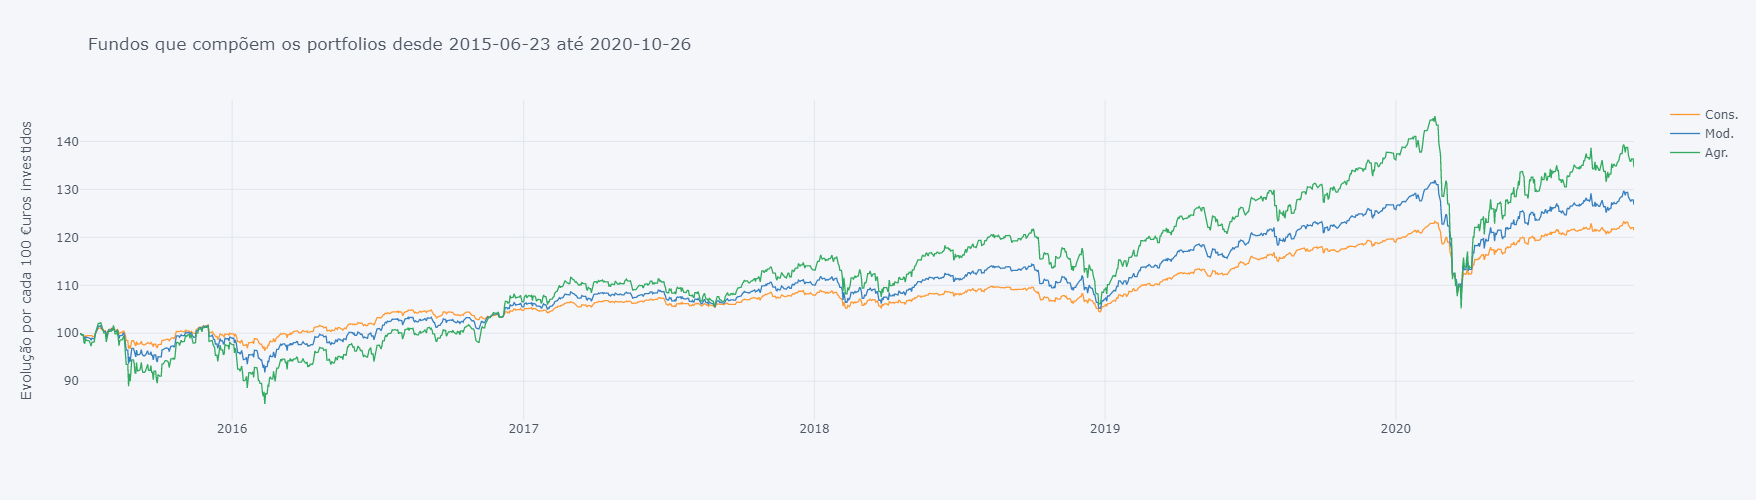

In [23]:
portfolios.iplot(dimensions=pl.dimensions, title='Fundos que compõem os portfolios desde ' +  Begin + ' até ' + End,
                 yTitle='Evolução por cada 100 €uros investidos')

In [24]:
# def compute_rolling_cagr_with_offset(data, years):
#     start = data.index[0]
#     end = data.index[-1]
#     start_offset = start + DateOffset(years=years)
#     end_offset   = end - DateOffset(years=years)
#     data_offset = data[start_offset:]
#     data = data[:end_offset]
#     df = (pd.DataFrame(data_offset.values / data.values) - 1)
#     df.columns = data_offset.columns
#     df.index = data_offset.index
#     df = df.groupby(df.index).last()
    
#     return df

In [25]:
def compute_rolling_cagr_with_shift(data, years):
    df = ((data / data.shift(365 * years, freq="D")).dropna()) -1
    df = df[~df.index.duplicated(keep='first')]
    return df

In [26]:
moderado.columns = ['moderado']
one_year_cons = compute_rolling_cagr_with_shift(moderado, years=1)
one_year_funds = compute_rolling_cagr_with_shift(fundos, years=1)

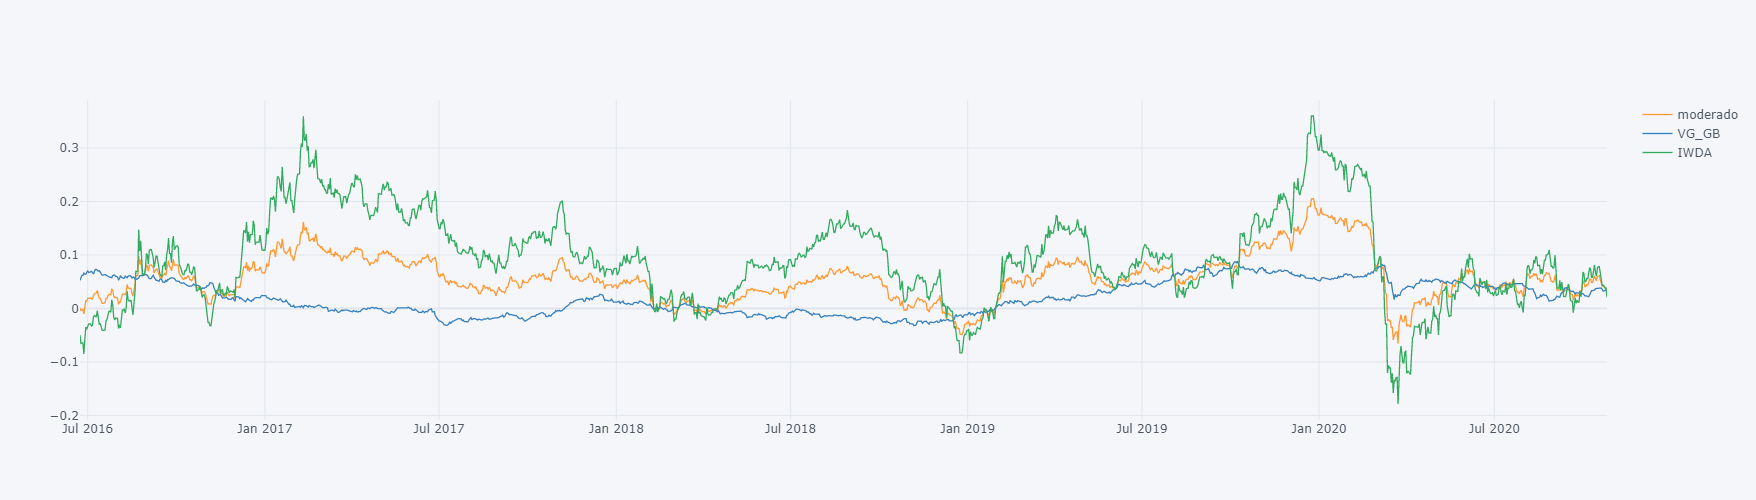

In [27]:
pl.merge_time_series(one_year_cons, one_year_funds).dropna().iplot(dimensions=pl.dimensions)

In [28]:
round(fa.compute_drawdowns(portfolios), 2).iplot(dimensions=fa.dimensions, title='Drawdowns desde ' +  Begin + ' até ' + End, yTitle='Percentagem')

NameError: name 'fa' is not defined

In [ ]:
pa.print_title('Quadro de performance do portfolio Conservador (70B/30E)')
pa.compute_ms_performance_table(portfolios[['Cons.']])

**Nota:** O "B" e o "E" querem dizer Bonds e Equity respectivamente

In [ ]:
pa.print_title('Quadro de performance do portfolio Moderado (50B/50E)')
pa.compute_ms_performance_table(portfolios[['Mod.']])

In [ ]:
pa.print_title('Quadro de performance do portfolio Agressivo (20B/80E)')
pa.compute_ms_performance_table(portfolios[['Agr.']])

In [ ]:
pa.print_title('Quadro de retornos anuais dos portfolios')
fundos_norm = portfolios.copy()

# Resampling to yearly (business year)
yearly_quotes_fundos = fundos_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes_fundos = pd.concat([yearly_quotes_fundos.iloc[:1], yearly_quotes_fundos])
yearly_quotes_fundos = pd.concat([pd.DataFrame(fundos_norm.iloc[0]).transpose(), yearly_quotes_fundos.iloc[1:]])

# Returns
yearly_returns_fundos = ((yearly_quotes_fundos / yearly_quotes_fundos.shift(1)) - 1) * 100
yearly_returns_fundos = yearly_returns_fundos.set_index([list(range(fundos_norm.index[0].year - 1, fundos_norm.index[-1].year + 1))]).drop(fundos_norm.index[0].year - 1)

# Calcular em valores percentuais
yearly_returns_fundos = yearly_returns_fundos / 100

# Sns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(12, 3.5)

ax = sns.heatmap(yearly_returns_fundos.transpose(), annot=True, cmap="RdYlGn", linewidths=.2, cbar=False, center=0.02, fmt='.2%')
plt.yticks(rotation=360)
plt.title('Yearly performance')
plt.show()

### Questão: Posso usar o IGGH/EUNA (iShares Core Global Aggregate Bond UCITS ETF) em vez do Vanguard Global bond index fund (IE00BGCZ0933)?

In [ ]:
ISINs = ['IE00B18GC888', 'AGGH_oficial']
Nomes = ['VG_GB', 'AGGH']

fundos = pd.read_csv('C:/Users/Luis/Google Drive/_GitHub/Backtester/Data/Cotacoes_diarias_all.csv', index_col = 'Date', parse_dates = True)[ISINs]

fundos.columns = Nomes
fundos = fundos.dropna()
fundos = fa.normalize(fundos.loc[:'2020-04-30'])

Begin = str(fundos.iloc[0].name)[0:10]
End = str(fundos.iloc[-1].name)[0:10]

In [ ]:
fundos.iplot(dimensions=pa.dimensions, title = 'Vanguard Global bond index fund vs iShares Core Global Aggregate Bond UCITS ETF',
            yTitle='Crescimento de cada 100 €uros investidos')

Os activos parecem ser suficientemente semelhantes para se poder usar qualquer um deles.

## Comparação do Vanguard Global Bond com o Xtrackers II Global Government Bond UCITS ETF 1C - EUR Hedged

In [ ]:
# Downloading funds and creating quotes and returns dataframes
Begin = '2000-03-10'
# End = '2017-08-20' # Só activas se quiseres que acabe num dia especifíco 

Tickers =  ['DBZB.XETRA']

ETFs = pd.DataFrame()

# Download
for ticker in Tickers:
    url = "https://eodhistoricaldata.com/api/eod/" + str(ticker) + "?api_token=5c982bff80deb2.22427269&period=d."
    ETF = pd.read_csv(url, index_col = 'Date', parse_dates = True)[['Adjusted_close']].iloc[:-1, :]
    ETFs = ETFs.merge(ETF, left_index = True, right_index = True, how='outer')
    
ETFs.columns = Tickers
ETFs = ETFs.fillna(method='ffill')
ETFs = ETFs.replace(to_replace=0, method='ffill')
ETFs.columns = ['DBZB']

ISINs = ['IE00B18GC888']
Nomes = ['VG_GB']

fundos = pd.read_csv('C:/Users/Luis/Google Drive/_GitHub/Backtester/Data/Cotacoes_diarias_all.csv', index_col = 'Date', parse_dates = True)[ISINs]

fundos.columns = Nomes
fundos = fundos.dropna()

Begin = str(fundos.iloc[0].name)[0:10]
End = str(fundos.iloc[-1].name)[0:10]

fundos = pa.merge_time_series(ETFs, fundos, how='inner')
fundos = pa.normalize(fundos)

In [ ]:
fundos.iplot(dimensions=pa.dimensions,
             title= 'Vanguard Global Bond vs Xtrackers II Global Government Bond',
             yTitle='Valor por cada 100 €uros investidos')

In [ ]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)